In [1]:
import os
os.chdir('..')

In [2]:
import pandas as pd
import pickle as pkl
import tqdm
from datetime import datetime

pd.set_option('display.max_columns', 500)

DATE_FORMAT = '%a %b %d %H:%M:%S %z %Y'

# Getting Count of Tweets

In [3]:
%%time
NB_OF_TWEETS = 0
with open('./data/twitter-election-data-slim.p', 'rb') as f:
    try:
        while True:
            _ = pkl.load(f)
            NB_OF_TWEETS += 1
    except EOFError:
        pass
print(NB_OF_TWEETS)

827232
CPU times: user 23.7 s, sys: 1.04 s, total: 24.7 s
Wall time: 24.7 s


# Extract Users, Separate Tweets & ReTweets

## Helper methods

In [4]:
def add_or_update_user(user):
    if user['id'] not in users or user['update_date'] > users[user['id']]['update_date']:
        users[user['id']] = user
        
def prepare_tweet_and_author(tweet, occurence_date=None):
    tweet_date = datetime.strptime(tweet['created_at'], DATE_FORMAT)
    if not occurence_date:
        occurence_date = tweet_date
    tweet['created_at'] = tweet_date
    tweet['occurence_date'] = occurence_date
    user = tweet['user']
    user['update_date'] = tweet_date
    tweet['user'] = user['id']
    tweet['username'] = user['screen_name']
    
    if 'extended_tweet' in tweet:
        tweet['display_text_range'] = tweet['extended_tweet']['display_text_range']
        tweet['text'] = tweet['extended_tweet']['full_text']
        tweet['entities'] = tweet['extended_tweet']['entities']
        del tweet['extended_tweet']
    
    tweet['hashtags'] = tweet['entities']['hashtags']
    tweet['mentions'] = [ment['screen_name'] for ment in tweet['entities']['user_mentions']]
    del tweet['entities']
    
    if 'quoted_status' in tweet:
        del tweet['quoted_status']
        del tweet['quoted_status_permalink']
        del tweet['quoted_status_id']
        del tweet['quoted_status_id_str']
    if 'extended_entities' in tweet:
        del tweet['extended_entities']
    
    return tweet, user

## Processing - separate retweets and original tweets

Original tweets may not yet be full dataset. Retweets contain nested tweets, that will be merged with original tweets in next steps.

In [5]:
%%time

retweets = []
retweeted = []
original_not_retweeted = []
users = {}

with open('./data/twitter-election-data-slim.p', 'rb') as f:
    for i in tqdm.tqdm_notebook(range(NB_OF_TWEETS)):
        tweet = pkl.load(f)
        tweet, author = prepare_tweet_and_author(tweet)

        add_or_update_user(author)
        
        if 'retweeted_status' not in tweet:
            original_not_retweeted.append(tweet)
        else:
            orig_tw, orig_aut = prepare_tweet_and_author(tweet['retweeted_status'], tweet['created_at'])
            del tweet['retweeted_status']
            add_or_update_user(orig_aut)
            retweeted.append(orig_tw)
            retweets.append(tweet)


CPU times: user 1min 9s, sys: 2.53 s, total: 1min 11s
Wall time: 1min 11s


In [6]:
print("Nb of original tweets:", len(original_not_retweeted))
print("Nb of retweets:", len(retweets))
print("Nb of retweeted:", len(retweeted))
print()
print("Is sum of original tweets count & retweets count equal to original dataset count?")
print(len(original_not_retweeted) + len(retweets) == NB_OF_TWEETS)

Nb of original tweets: 271533
Nb of retweets: 555699
Nb of retweeted: 555699

Is sum of original tweets count & retweets count equal to original dataset count?
True


## Helper method

Filter set of tweets so that the most recent version of tweet is left.

(When tweet is retweeted multiple times, we get multiple snapshots of it. Some stats, e.g. likes may be updated, so we are interested in the most recent copy)

In [7]:
def drop_duplicates_not_up_to_date(tweets):
    to_leave = {}
    for tweet in tweets:
        if (tweet['id'] not in to_leave 
            or tweet['occurence_date'] > to_leave[tweet['id']]['occurence_date']):
            to_leave[tweet['id']] = tweet
    return list(to_leave.values())

## Final step - removing duplicates from original tweets and retweets

In [8]:
original_tweets = original_not_retweeted + retweeted
original_tweets = drop_duplicates_not_up_to_date(original_tweets)

retweets = drop_duplicates_not_up_to_date(retweets)

In [9]:
print("Final count of original tweets:", len(original_tweets))
print("Final count of retweets:", len(retweets))

Final count of original tweets: 276260
Final count of retweets: 555448


In [10]:
print(len(original_tweets) + len(retweets), NB_OF_TWEETS)

831708 827232


# Building DataFrames

In [11]:
retweets_df = pd.DataFrame(retweets)
retweets_df.head()

,contributors,coordinates,created_at,favorite_count,favorited,filter_level,geo,hashtags,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,mentions,occurence_date,place,possibly_sensitive,quote_count,quoted_status_id,quoted_status_id_str,reply_count,retweet_count,retweeted,source,text,timestamp_ms,truncated,user,username,withheld_in_countries
0,None,None,2018-10-28 23:35:59+00:00,0,False,low,None,[],1056691077053382656,1056691077053382656,None,None,None,None,None,False,pl,[tcimoszewicz],2018-10-28 23:35:59+00:00,None,NaN,0,NaN,NaN,0,0,False,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",RT @tcimoszewicz: Mam nadzieję że poszkodowani...,1540769759797,False,756556803463348226,lukaszzplakatu,NaN
1,None,None,2018-10-28 23:36:16+00:00,0,False,low,None,[],1056691146930483200,1056691146930483200,None,None,None,None,None,True,pl,"[sikorskiradek, Macierewicz_A, pisorgpl]",2018-10-28 23:36:16+00:00,None,NaN,0,NaN,NaN,0,0,False,"<a href=""http://twitter.com/#!/download/ipad"" ...","RT @sikorskiradek: Twierdzenie, że @Macierewic...",1540769776457,False,885746072798232577,Leszek15558157,NaN
2,None,None,2018-10-28 23:36:17+00:00,0,False,low,None,[],1056691150491394048,1056691150491394048,None,None,None,None,None,False,pl,[KochanowskiJacq],2018-10-28 23:36:17+00:00,None,NaN,0,NaN,NaN,0,0,False,"<a href=""http://twitter.com/download/android"" ...","RT @KochanowskiJacq: Strasznie jest mi głupio,...",1540769777306,False,498226970,marcinwojtera,NaN
3,None,None,2018-10-28 23:36:21+00:00,0,False,low,None,[],1056691166551392256,1056691166551392256,None,None,None,None,None,False,pl,[tcimoszewicz],2018-10-28 23:36:21+00:00,None,NaN,0,NaN,NaN,0,0,False,"<a href=""http://twitter.com/download/android"" ...",RT @tcimoszewicz: Mam nadzieję że poszkodowani...,1540769781135,False,1018850865829072897,Marcin74961390,NaN
4,None,None,2018-10-28 23:36:22+00:00,0,False,low,None,[],1056691171681075200,1056691171681075200,None,None,None,None,None,False,pl,[bezczelny],2018-10-28 23:36:22+00:00,None,NaN,0,NaN,NaN,0,0,False,"<a href=""http://twitter.com/download/android"" ...",RT @bezczelny: Podsumujmy tydzień:\n\n- Prezes...,1540769782358,False,498226970,marcinwojtera,NaN


In [12]:
original_df = pd.DataFrame(original_tweets)
original_df.head()

,contributors,coordinates,created_at,display_text_range,favorite_count,favorited,filter_level,geo,hashtags,id,id_str,in_reply_to_screen_name,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,is_quote_status,lang,mentions,occurence_date,place,possibly_sensitive,quote_count,quoted_status_id,quoted_status_id_str,reply_count,retweet_count,retweeted,scopes,source,text,timestamp_ms,truncated,user,username,withheld_in_countries
0,None,None,2018-10-28 23:35:48+00:00,"[0, 109]",0,False,low,None,"[{'text': 'Warszawa', 'indices': [76, 85]}]",1056691029846491139,1056691029846491139,None,NaN,None,NaN,None,False,pl,[],2018-10-28 23:35:48+00:00,None,False,0,NaN,NaN,0,0,False,NaN,"<a href=""https://echowarszawy.pl"" rel=""nofollo...",KMPSP Warszawa: 23.10.2018 - Drzewo powalone n...,1540769748542,False,965943739809239040,EchoWarszawy,NaN
1,None,None,2018-10-28 23:35:51+00:00,"[48, 290]",0,False,low,None,[],1056691042106400768,1056691042106400768,SebNow82,1.056498e+18,1056497877588107266,9.009772e+17,900977200459075584,False,pl,"[SebNow82, ChiefRobert2, Immanuela_Kant, smok05]",2018-10-28 23:35:51+00:00,None,NaN,0,NaN,NaN,0,0,False,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",@SebNow82 @ChiefRobert2 @Immanuela_Kant @smok0...,1540769751465,True,870751323549040640,dodi6319,NaN
2,None,None,2018-10-28 23:35:56+00:00,"[50, 330]",0,False,low,None,[],1056691065200304128,1056691065200304128,rafalch2,1.055956e+18,1055955548984741889,7.428777e+17,742877683646922752,False,pl,"[rafalch2, KLubnauer, Nowoczesna, wlodekczarza...",2018-10-28 23:35:56+00:00,None,NaN,0,NaN,NaN,0,0,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",@rafalch2 @KLubnauer @Nowoczesna @wlodekczarza...,1540769756971,True,1025517195223281664,Fiona11701355,NaN
3,None,None,2018-10-28 23:35:59+00:00,"[20, 72]",0,False,low,None,[],1056691075727982592,1056691075727982592,wkrawcz1,1.056689e+18,1056688549007949824,7.167425e+17,716742538498060294,False,pl,"[wkrawcz1, pisorgpl]",2018-10-28 23:35:59+00:00,None,NaN,0,NaN,NaN,0,0,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...",@wkrawcz1 @pisorgpl W PiS to normalne. Wszyscy...,1540769759481,False,811556244892872704,Paul4Anka,NaN
4,None,None,2018-10-28 23:36:10+00:00,NaN,0,False,low,None,[],1056691121097752576,1056691121097752576,None,NaN,None,NaN,None,True,pl,[],2018-10-28 23:36:10+00:00,None,NaN,0,NaN,NaN,0,0,False,NaN,"<a href=""http://twitter.com"" rel=""nofollow"">Tw...","Czasami żałuję, że Krysia mnie zablokowała😘",1540769770298,False,1004022955045728256,JanKiebasa3,NaN


# Saving data

In [13]:
SAVE_CSV = False

In [14]:
if SAVE_CSV:
    retweets_df.to_csv('./data/retweets.csv.gz', index=False, compression='gzip')

with open('./data/retweets.p', 'wb') as f:
    pkl.dump(retweets_df, f)

In [15]:
if SAVE_CSV:
    original_df.to_csv('./data/original_tweets.csv.gz', index=False, compression='gzip')

with open('./data/original_tweets.p', 'wb') as f:
    pkl.dump(original_df, f)

### Pickling people!

In [16]:
with open('./data/users.p', 'wb') as f:
    pkl.dump(users, f)

# Preprocessed data from Kuba

In [4]:
with open('./data/preprocessed_dataset.pkl', 'rb') as f:
    prep = pkl.load(f)

In [5]:
prep

,hashtags,text
0,[Warszawa],KMPSP Warszawa: - Drzewo powalone na samochód ...
1,[],Tak Gruzini jak i Ukraińcy w Polsce są od lat ...
2,[],"POstępowy 'mojrzeł"" jest tęczowy i ryje się do..."
3,[],W PiS to normalne. Wszyscy są winni tylko nie ...
4,[],"Czasami żałuję, że Krysia mnie zablokowała"
5,[],"Mam rodzine w Lodzi, zawsze glosowali na SLD. ..."
6,[],"Poszedłem do pracy, wróciłem a tu taka niespod..."
7,[],"PSL złapał wiatr w żagle, bo wygrał wybory pre..."
8,[],"A myślałam ,że SLD na głowę na karku a tu...zm..."
9,[],"""Warszawa"""


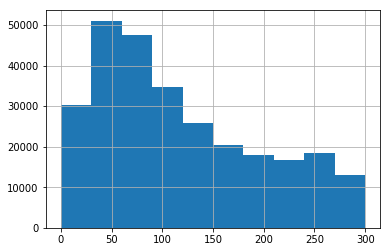

In [7]:
prep.text.str.len().hist()

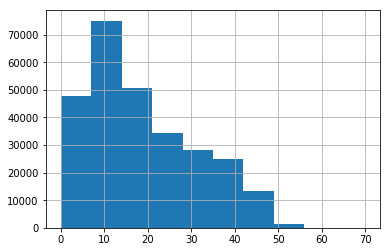

In [9]:
prep.text.str.split().str.len().hist()

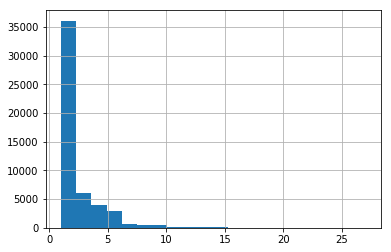

In [22]:
prep[prep.hashtags.str.len()>0].hashtags.str.len().hist(bins=20)

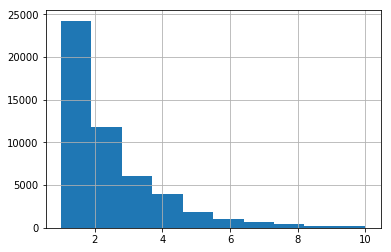

In [24]:
prep[(prep.hashtags.str.len()>0) & (prep.hashtags.str.len()<11)].hashtags.str.len().hist(bins=10)